# Consts

In [1]:
height = 64
width = 256

vocab = "0123456789авекмнорстух~"
blank = "~"

# Preprocessing

In [16]:
import cv2
import numpy as np
import torch

In [41]:
class Preprocessor:
    def __init__(self, height, width):
        self.height = height
        self.width = width
    
    def resize(self, img):
        h, w = img.shape[:2]
        r = self.height / float(h)
        new_w = int(w * r)
        # new_width cannot be bigger than width
        if new_w >= self.width:
            img = cv2.resize(img, (self.width, self.height), cv2.INTER_CUBIC)
        else:
            delta = self.width - new_w
            img = cv2.resize(img, (new_w, self.height), cv2.INTER_CUBIC)
            pad_left = 0
            pad_right = delta

            pad_value = np.zeros(len(img.shape)) + np.median(img)
            img = cv2.copyMakeBorder(
                img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=pad_value
            )

        return img
    
    def normalize(self, img):
        img = img.astype(np.float32) / 255
        img = (img - img.mean()) / (img.std() + 1e-8)
        return img

    def __call__(self, images):
        batch = []
        for img in images:
            img = self.resize(img)
            img = self.normalize(img)
            np.transpose(img, (2, 0, 1))
            batch.append(np.transpose(img, (2, 0, 1)))
        return torch.tensor(np.array(batch))

In [42]:
img = cv2.imread('/mnt/nvme12TB/DATASETS-MANAGED/OCR/ocr_plates_raw/images/Day_00027_19.03.20/Day_00027_19.03.20.1811_0.bmp')

In [43]:
preprocessor = Preprocessor(height, width)

In [50]:
batch = preprocessor([img])

In [45]:
batch.shape

torch.Size([1, 3, 64, 256])

# Inference

In [46]:
model = torch.jit.load('/mnt/models/Russian_LPR/effnetb3+light_aug/weights/best.script')

In [47]:
device = 'cuda'

In [48]:
model.to(device)
model.eval()

RecursiveScriptModule(
  original_name=Model
  (backbone): RecursiveScriptModule(
    original_name=EfficientNet
    (backbone): RecursiveScriptModule(
      original_name=EfficientNet
      (conv_stem): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(
        original_name=BatchNormAct2d
        (drop): RecursiveScriptModule(original_name=Identity)
        (act): RecursiveScriptModule(original_name=SiLU)
      )
      (blocks): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(
            original_name=DepthwiseSeparableConv
            (conv_dw): RecursiveScriptModule(original_name=Conv2d)
            (bn1): RecursiveScriptModule(
              original_name=BatchNormAct2d
              (drop): RecursiveScriptModule(original_name=Identity)
              (act): RecursiveScriptModule(original_name=SiLU)
            )
            (se): Recursi

In [65]:
batch = torch.tensor(np.stack([img, img, img, img])) # если несколько картинок

In [66]:
batch.shape

torch.Size([4, 3, 64, 256])

In [51]:
out = model(batch.to(device))

In [52]:
out.shape

torch.Size([1, 64, 23])

# Postprocessing

In [60]:
class Postprocessor:
    def __init__(self, vocab: str, blank: str):
        self.vocab = vocab
        self.blank = blank
        self.blank_index = vocab.index(blank)
        
        self.num_to_char = dict()
        for i, c in enumerate(vocab):
            self.num_to_char[i] = c
    
    def _decode_sample(self, sample):
        label = ""
        for i in sample:
            if i == self.blank_index:
                break
            label += self.num_to_char.get(i, "")
        return label

    def __call__(self, batch):
        """greedy search decode raw output batch from NN
        Args:
            batch (torch.tensor): prediction in shape [B, T, V]
            B - batch size
            T - timestemps
            V - vocab size

        Returns:
            list: labels
        """

        batch = torch.softmax(batch, 2)
        batch = torch.argmax(batch, 2)
        batch = batch.detach().cpu().numpy()

        labels = []
        for sample in batch:
            sample = [sample[0]] + [c for i, c in enumerate(sample[1:]) if c != sample[i]]
            sample = [s for s in sample if s != self.blank_index]
            label = self._decode_sample(sample)
            labels.append(label)
        return labels


In [61]:
postprocessor = Postprocessor(vocab, blank)

In [62]:
postprocessor(out)

['м038ср777']

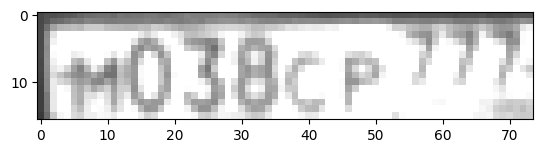

In [64]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
class OCRPipeline:
    def __init__(self, model_path: str, preprocessor: Preprocessor, postprocessor: Postprocessor, device: str = 'cuda'):
        self.model = torch.jit.load(model_path)
        self.device = device
        self.model.to(device)
        self.model.eval()
        self.preprocessor = preprocessor
        self.postprocessor = postprocessor
        
    
    def __call__(self, images: list):
        batch = self.preprocessor(images)
        out = self.model(batch.to(self.device))
        labels = self.postprocessor(out)
        return labels


In [ ]:
pipe = OCRPipeline(
    '/mnt/models/Russian_LPR/effnetb3+light_aug/weights/best.script',
    preprocessor, postprocessor,
)

pipe([img])